In [1]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
from my_commonfunctions import *
from scipy import ndimage
from tqdm import tqdm
import cv2

In [3]:
def zoom_in(staff_lines_removed):
    notes_masked_only = []
    notes_zoomed_in = []
    notes_contours = []


    staff_lines_removed = np.ascontiguousarray(staff_lines_removed)

    contours, h = cv2.findContours(staff_lines_removed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours_sorted_by_area = sorted(contours, key=cv2.contourArea, reverse=True)
    
    max_area_contour = contours_sorted_by_area[0]
    x, y, w, h = cv2.boundingRect(max_area_contour)
    a0 = w*h

    max_area_contour_mask = contours_mask([max_area_contour], staff_lines_removed.shape)
    #my_show_images([staff_lines_removed, max_area_contour_mask], dpi=80, row_max=2)
    masked_biggest = np.copy((staff_lines_removed * (max_area_contour_mask > 128)))
    zoomed_in_biggest = np.copy((staff_lines_removed * (max_area_contour_mask > 128))[y:y+h, x:x+w])
    
    if len(contours_sorted_by_area) == 1:
        # Append zoomed_in_biggest only
        notes_masked_only.append(masked_biggest)
        notes_zoomed_in.append(zoomed_in_biggest)
        notes_contours.append(max_area_contour)
    else:
        second_max_area_contour = contours_sorted_by_area[1]
        x1, y1, w1, h1 = cv2.boundingRect(second_max_area_contour)
        a1 = w1*h1
        
        if a1 / a0 > 0.4:
            second_max_area_contour_mask = contours_mask([second_max_area_contour], staff_lines_removed.shape)
            masked_second_biggest = np.copy((staff_lines_removed * (second_max_area_contour_mask > 128)))
            zoomed_in_second_biggest = np.copy((staff_lines_removed * (second_max_area_contour_mask > 128))[y1:y1+h1, x1:x1+w1])

            # Append zoomed_in_biggest & zoomed_in_second_biggest in correct order
            if x > x1:
                # Append zoomed_in_biggest first
                notes_masked_only.append(masked_biggest)
                notes_zoomed_in.append(zoomed_in_biggest)
                notes_contours.append(max_area_contour)

                notes_masked_only.append(masked_second_biggest)
                notes_zoomed_in.append(zoomed_in_second_biggest)
                notes_contours.append(second_max_area_contour)
            else:
                # Append zoomed_in_biggest second
                notes_masked_only.append(masked_second_biggest)
                notes_zoomed_in.append(zoomed_in_second_biggest)
                notes_contours.append(second_max_area_contour)
                
                notes_masked_only.append(masked_biggest)
                notes_zoomed_in.append(zoomed_in_biggest)
                notes_contours.append(max_area_contour)
        else:
            # Append zoomed_in_biggest only
            notes_masked_only.append(masked_biggest)
            notes_zoomed_in.append(zoomed_in_biggest)
            notes_contours.append(max_area_contour)

    #print(len(notes_masked_only), len(notes_zoomed_in), len(staff_lines), len(notes_contours))
    return notes_masked_only, notes_zoomed_in, notes_contours

In [4]:
def add_padding(img_gray, ww, hh, color):
    ht, wd = img_gray.shape[:2]

    # create new image of desired size and color (blue) for padding
    result = np.full((hh, ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img_gray

    return result

# Deleting old data

In [45]:
data_path = 'Symbols/data/'
for cfn in os.listdir(data_path):
    try:
        for fn in tqdm(os.listdir(data_path+cfn), desc=cfn):
            if fn.endswith('.png'):
                image_path = data_path+cfn+'/'+fn
                #print(image_path)
                os.remove(image_path)
    except:
        print('\r'+cfn+' Something went wrong ....')
        continue

augmentation_dot: 100%|██████████| 1/1 [00:00<00:00, 2668.13it/s]
eighth_note: 0it [00:00, ?it/s]
half_note_upside_down: 0it [00:00, ?it/s]
treple_clef: 0it [00:00, ?it/s]
thirty_second_note_upside_down: 0it [00:00, ?it/s]
double_flat_accidental: 0it [00:00, ?it/s]
quarter_note_upside_down: 0it [00:00, ?it/s]
treple_clef_upside_down: 100%|██████████| 228/228 [00:00<00:00, 6108.68it/s]
whole_note: 0it [00:00, ?it/s]
flat_accidental: 0it [00:00, ?it/s]
natural_accidental: 0it [00:00, ?it/s]
sharp_accidental: 0it [00:00, ?it/s]
.DS_Store Something went wrong ....
time_signature_4: 100%|██████████| 449/449 [00:00<00:00, 1972.80it/s]
thirty_second_note: 0it [00:00, ?it/s]
quarter_note: 0it [00:00, ?it/s]
time_signature_2: 0it [00:00, ?it/s]
half_note: 0it [00:00, ?it/s]
eighth_note_upside_down: 100%|██████████| 448/448 [00:00<00:00, 3675.63it/s]
bar_line_thick: 0it [00:00, ?it/s]
sixtheenth_note: 100%|██████████| 450/450 [00:00<00:00, 1272.57it/s]
double_sharp_accidental: 0it [00:00, ?it/s]

# Loading samples

In [5]:
imgs = []
names = []
for fn in os.listdir('Symbols'):
    if fn.endswith('.png'):
        image_path = 'Symbols/'+fn
        img = 255-my_imread_gray(image_path)
        h, w = img.shape
        img_padding = add_padding(img, ww=int(w*2.5), hh=int(h*1.5), color=0)
        # my_show_images([img, img_padding], dpi=100, row_max=2)
        imgs.append(img_padding)
        names.append(fn.split('.png')[0])

In [6]:
print(names)

['sixtheenth_note', 'bar_line', 'eighth_note_upside_down', 'sixtheenth_note_upside_down', 'time_signature_4', 'treple_clef_upside_down', 'whole_note', 'time_signature_2', 'half_note', 'thirty_second_note', 'eighth_note', 'natural_accidental', 'bar_line_thick', 'treple_clef', 'double_sharp_accidental', 'thirty_second_note_upside_down', 'quarter_note', 'quarter_note_upside_down', 'double_flat_accidental', 'half_note_upside_down', 'augmentation_dot', 'flat_accidental', 'sharp_accidental']


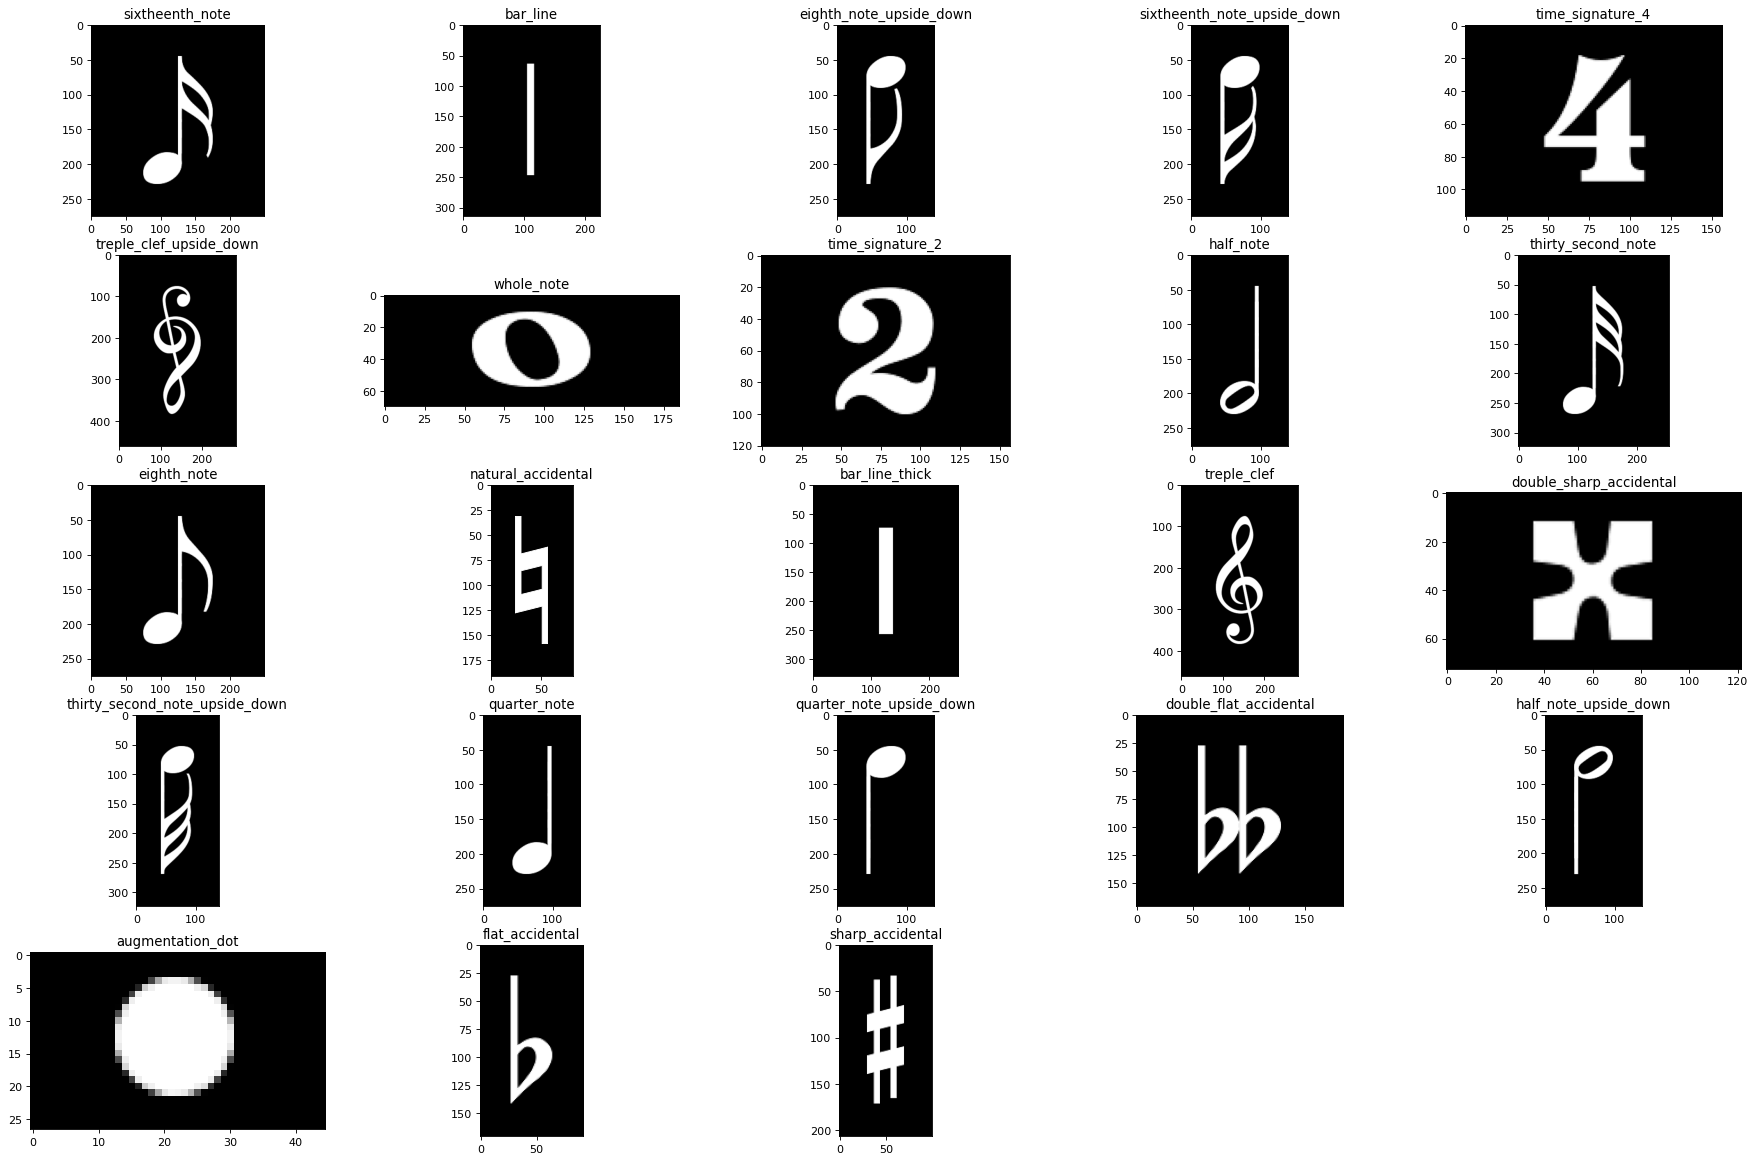

In [9]:
my_show_images(imgs, names, dpi=80, row_max=5)

In [46]:
for img, fn in zip(imgs, names):
	print('Augmenting \""' + fn + '\" .....')

	# convert to numpy array
	data = img_to_array(img)
	data = data.reshape((1, ) + data.shape)

	# expand dimension to one sample
	#samples = expand_dims(data, 0)
	# create image data augmentation generator
	datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.05, shear_range=20, dtype=np.uint8)
	'''# prepare iterator
	it = datagen.flow(samples, batch_size=1)
	# generate samples and plot
	for i in range(9):
		# define subplot
		pyplot.subplot(330 + 1 + i)
		# generate batch of images
		batch = it.next()
		# convert to unsigned integers for viewing
		image = batch[0].astype('uint8')
		# plot raw pixel data
		pyplot.imshow(image)'''

	rr = 400

	for img, i in zip(datagen.flow(data), range(rr)):
		img = img.squeeze().astype(np.uint8)
		zoomed_in = zoom_in(img)[1][0]
		h, w = zoomed_in.shape
		img_padding = add_padding(zoomed_in, ww=int(w+40/aspect_ratio), hh=int(h+h*aspect_ratio), color=0)
		cv2.imwrite('Symbols/data/'+fn+'/_0_'+str(i)+'.png', img_padding)
		
	
	datagen = ImageDataGenerator(rotation_range=0, zoom_range=0, shear_range=0, dtype=np.uint8)

	for x, val in zip(datagen.flow(data,                    #image we chose
		save_to_dir='Symbols/data/'+fn,     #this is where we figure out where to save
		save_format='png'),range(50)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
		pass

print('......DONE......')

	# show the figure
	# pyplot.show()

Augmenting ""sixtheenth_note" .....
Augmenting ""bar_line" .....
Augmenting ""eighth_note_upside_down" .....
Augmenting ""sixtheenth_note_upside_down" .....
Augmenting ""time_signature_4" .....
Augmenting ""treple_clef_upside_down" .....
Augmenting ""whole_note" .....
Augmenting ""time_signature_2" .....
Augmenting ""half_note" .....
Augmenting ""thirty_second_note" .....
Augmenting ""eighth_note" .....
Augmenting ""natural_accidental" .....
Augmenting ""bar_line_thick" .....
Augmenting ""treple_clef" .....
Augmenting ""double_sharp_accidental" .....
Augmenting ""thirty_second_note_upside_down" .....
Augmenting ""quarter_note" .....
Augmenting ""quarter_note_upside_down" .....
Augmenting ""double_flat_accidental" .....
Augmenting ""half_note_upside_down" .....
Augmenting ""augmentation_dot" .....
Augmenting ""flat_accidental" .....
Augmenting ""sharp_accidental" .....
......DONE......


In [21]:
?ImageDataGenerator

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format='channels_last',
    validation_split=0.0,
    interpolation_order=1,
    dtype='float32',
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.
 The data will be looped over (in batches).

# Arguments
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Di

In [21]:
?cv2.imwrite

Docstring:
imwrite(filename, img[, params]) -> retval
.   @brief Saves an image to a specified file.
.   
.   The function imwrite saves the image to the specified file. The image format is chosen based on the
.   filename extension (see cv::imread for the list of extensions). In general, only 8-bit
.   single-channel or 3-channel (with 'BGR' channel order) images
.   can be saved using this function, with these exceptions:
.   
.   - 16-bit unsigned (CV_16U) images can be saved in the case of PNG, JPEG 2000, and TIFF formats
.   - 32-bit float (CV_32F) images can be saved in PFM, TIFF, OpenEXR, and Radiance HDR formats;
.     3-channel (CV_32FC3) TIFF images will be saved using the LogLuv high dynamic range encoding
.     (4 bytes per pixel)
.   - PNG images with an alpha channel can be saved using this function. To do this, create
.   8-bit (or 16-bit) 4-channel image BGRA, where the alpha channel goes last. Fully transparent pixels
.   should have alpha set to 0, fully opaque pixels